We want to compute intra and inter network connectivty from covariance matrices, which should have been computed in `compare_maps.ipynb`

In [12]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import itertools

import joblib
import pandas as pd
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.connectivity import reshape_pvalues, network_to_network_connectivity
from bold_dementia.connectivity.matrices import plot_matrix
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.histograms import fast_hist
from bold_dementia.utils.iterables import unique, itersize

ATLAS = "schaeffer"
SOFT = False
matrices_path = Path(
    f"{config['data_dir']}/output/connectivity/atlas-{ATLAS}_strategy-high_pass-motion-wm_csf_motion-full_wm_csf-basic"
)

In [13]:
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")

n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

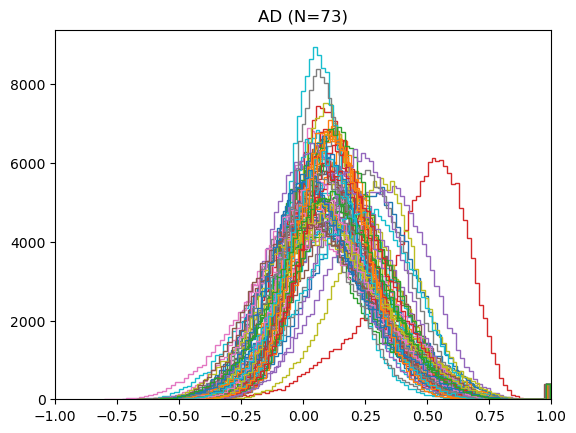

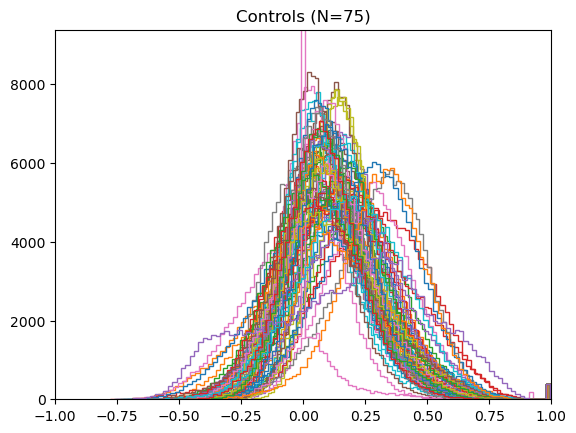

In [14]:
_, ax = fast_hist(AD_matrices, bins=100) 
ax.set_title(f"AD (N={n_AD})")
plt.show()

control_subsampled = control_matrices[::(n_controls//n_AD), :, :]
fig, ax2 = fast_hist(control_subsampled, bins=100) 
ax2.set_ylim(ax.get_ylim())
ax2.set_title(f"Controls (N={control_subsampled.shape[0]})")

plt.show()

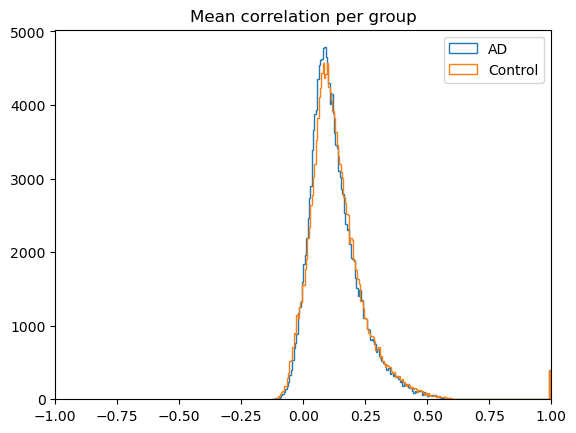

In [15]:
plt.hist(AD_matrices.mean(axis=0).flatten(), histtype="step", label="AD", bins=200)
plt.hist(control_matrices.mean(axis=0).flatten(), histtype="step", label="Control", bins=200)
plt.xlim(-1, 1)
plt.legend()
plt.title("Mean correlation per group")
plt.show()

In [16]:

def group_by_networks(macro_labels):
    networks = np.array(macro_labels)
    sort_index = np.argsort(networks)

    ticks = []
    lbls = []
    prev_label = None
    for i, label in enumerate(networks[sort_index]):
        if label != prev_label:
            ticks.append(i)
            lbls.append(label)
            prev_label = label

    ticks.append(i)
    return ticks, sort_index

In [17]:
ticks, sort_index = group_by_networks(atlas.macro_labels)

matrix_sort = np.ix_(sort_index, sort_index)
AD = AD_matrices.mean(axis=0)[matrix_sort]
control = control_matrices.mean(axis=0)[matrix_sort]

for mat in (AD, control):
    mat[list(range(n_regions)), list(range(n_regions))] = 0

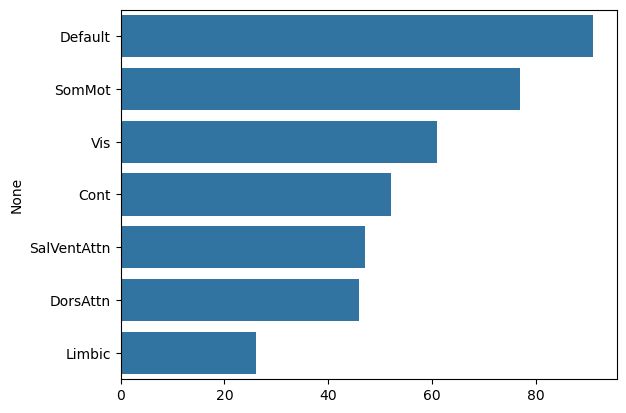

In [18]:

names, counts = np.unique(np.array(atlas.macro_labels), return_counts=True)
s = pd.Series(dict(zip(tuple(names), tuple(counts)))).sort_values(ascending=False)
sns.barplot(y=s.index, x=s.values)
plt.show()


In [19]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))

network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Cont              (0, 52)
Default         (52, 143)
DorsAttn       (143, 189)
Limbic         (189, 215)
SalVentAttn    (215, 262)
SomMot         (262, 339)
Vis            (339, 399)
dtype: object

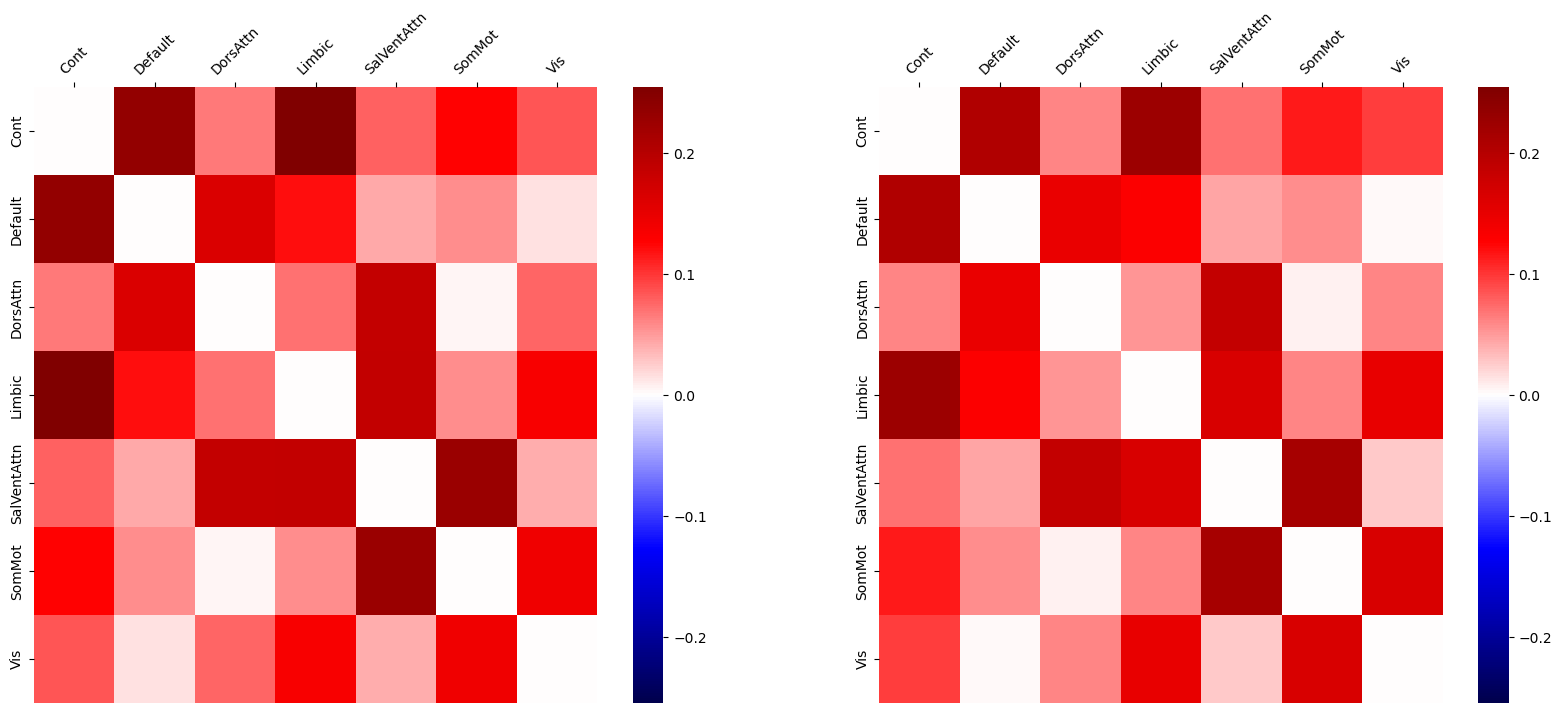

In [20]:
AD_nnc = network_to_network_connectivity(AD, network_to_idx)
control_nnc = network_to_network_connectivity(control, network_to_idx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


AD_nnc_mat = reshape_pvalues([ic[2] for ic in AD_nnc])
control_nnc_mat = reshape_pvalues([ic[2] for ic in control_nnc])

AD_span = np.max(abs(AD_nnc_mat))
control_span = np.max(abs(control_nnc_mat))
span = max(AD_span, control_span)
heat_kwargs = {"vmin": -span, "vmax":span, "cmap":"seismic", "xticklabels":unique_m, "yticklabels":unique_m}

sns.heatmap(AD_nnc_mat, ax=ax1, **heat_kwargs)

sns.heatmap(control_nnc_mat, ax=ax2, **heat_kwargs)

ax1.tick_params(axis="x", labelrotation=45)
ax1.xaxis.tick_top()
ax2.tick_params(axis='x', labelrotation=45)
ax2.xaxis.tick_top()

plt.show()

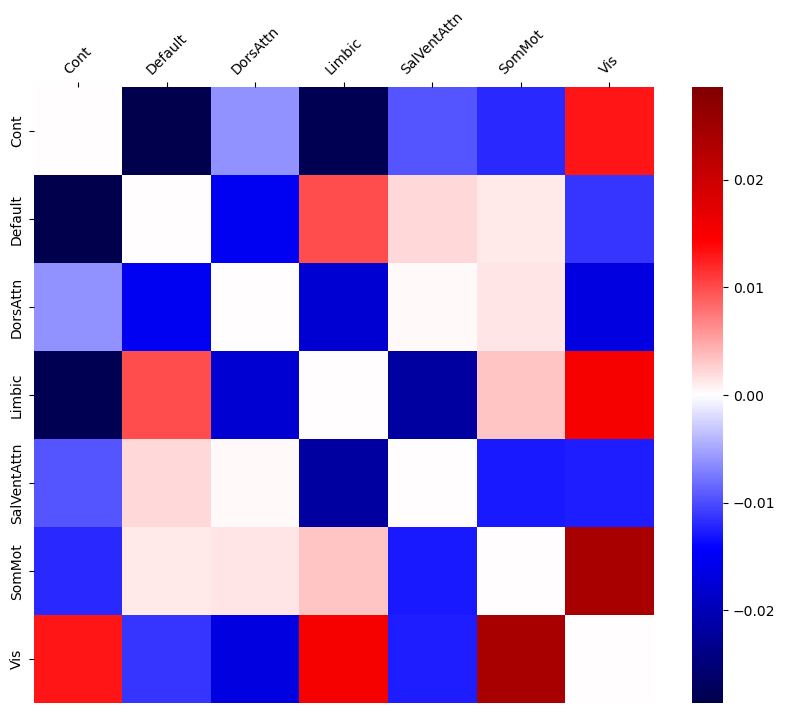

In [24]:
diff = control_nnc_mat - AD_nnc_mat
dspan = np.max(abs(diff))

try:
    heat_kwargs.pop("vmin")
    heat_kwargs.pop("vmax")
except KeyError:
    pass

plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(diff, vmin=-dspan, vmax=dspan, **heat_kwargs)
ax.xaxis.tick_top()
ax.tick_params(axis="x", labelrotation=45)

(array([ 4.,  2.,  8.,  8.,  2., 15.,  2.,  4.,  2.,  2.]),
 array([-0.02860436, -0.02334315, -0.01808193, -0.01282072, -0.00755951,
        -0.0022983 ,  0.00296292,  0.00822413,  0.01348534,  0.01874655,
         0.02400777]),
 [<matplotlib.patches.Polygon at 0x7f4e6238bd50>])

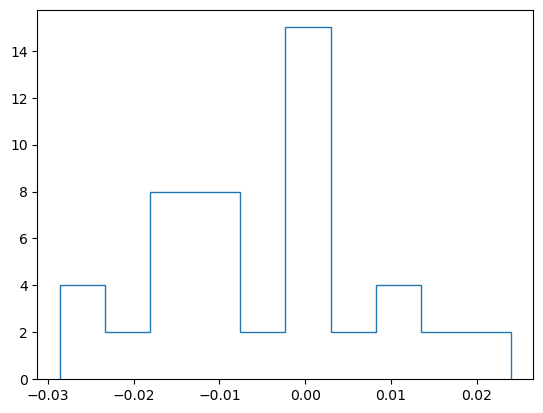

In [22]:
plt.hist(diff.flatten(), histtype="step")